# part1 reading data && cleaning

In [3]:
import pandas as pd
import numpy as np
import warnings
import bz2
import matplotlib.pyplot as plt
import re
from collections import Counter
import seaborn as sns
from joblib import Parallel, delayed
import multiprocessing
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 50)


## 📦 Data Conversion from .bz2 to .csv

In this stage, we will convert the original Amazon Reviews dataset, which is in `.bz2` compressed JSON format, into a `.csv` format for easier processing and analysis.


In [4]:
# 📦 Function to decompress .bz2 files to .txt
def decompress_bz2(file_path, output_path):
    with bz2.open(file_path, 'rt', encoding='utf-8') as file:
        with open(output_path, 'w', encoding='utf-8') as out_file:
            out_file.write(file.read())


In [5]:
# 📦 Decompress the training file (you can do the same for test if needed)
decompress_bz2('/kaggle/input/amazonreviews/train.ft.txt.bz2', 'train.ft.txt')
decompress_bz2('/kaggle/input/amazonreviews/test.ft.txt.bz2', 'test.ft.txt')


In [6]:
# 📥 Function to parse the decompressed text file
def parse_data(file_path):
    data = []
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            label, text = line.split(' ', 1)
            label = int(label.replace('__label__', ''))
            data.append((label, text.strip()))
    return pd.DataFrame(data, columns=['label', 'text'])


In [7]:
# 📥 Load the training data into a DataFrame
train_df = parse_data('train.ft.txt')


# 🔍 Inspect Labels: Pie Chart

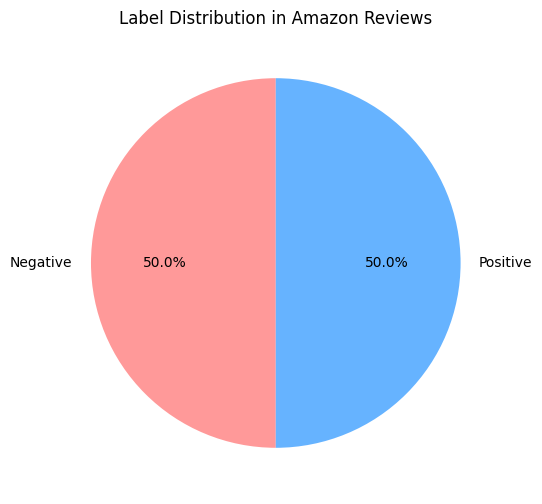

In [8]:
label_counts = train_df['label'].value_counts().sort_index()
label_names = {1: 'Negative', 2: 'Positive'}
labels = [label_names[i] for i in label_counts.index]
plt.figure(figsize=(6, 6))
plt.pie(label_counts, labels=labels, autopct='%1.1f%%', startangle=90, colors=['#ff9999', '#66b3ff'])
plt.title('Label Distribution in Amazon Reviews')
plt.show()


## 🧹 Amazon Reviews for Sentiment Analysis: Data Cleaning

In [9]:
train_df

,label,text
0,2,Stuning even for the non-gamer: This sound tra...
1,2,The best soundtrack ever to anything.: I'm rea...
2,2,Amazing!: This soundtrack is my favorite music...
3,2,Excellent Soundtrack: I truly like this soundt...
4,2,"Remember, Pull Your Jaw Off The Floor After He..."
...,...,...
3599995,1,Don't do it!!: The high chair looks great when...
3599996,1,"Looks nice, low functionality: I have used thi..."
3599997,1,"compact, but hard to clean: We have a small ho..."
3599998,1,what is it saying?: not sure what this book is...


# 🏗 NLTK Setup

In [10]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# 🏗 Download necessary NLTK datasets
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [11]:
print(stopwords.words("english")[:10])
print('____________________________________________________________________________________')
print(WordNetLemmatizer().lemmatize("children"))
print('____________________________________________________________________________________')
print(WordNetLemmatizer().lemmatize("runs", pos='v'))  # 'v' = verb


['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an']
____________________________________________________________________________________
child
____________________________________________________________________________________
run


In [12]:
# 🛡 Define stopwords, keeping important modifiers like 'not', 'no', etc.
stop_words = set(stopwords.words('english'))
words_to_keep = ["not", "no", "never", "neither", "nor", "very", 
                 "really", "too", "extremely", "quite", "but", "however", 
                 "although", "though", "if", "unless", "except"]

# 🛡 Final stopwords set after removing selected words
stop_words = [word for word in stop_words if word not in words_to_keep]


In [13]:

def cleaning(data):
    data = re.sub('http\S+', '', data).strip()
    data = re.sub('www\S+', '', data).strip()

    data = re.sub('#\S+', '', data).strip()

    data = re.sub('@\S+', '', data).strip()

    data = data.replace("'", "")

    text_tokens = word_tokenize(data.lower())

    tokens_without_punc = [w for w in text_tokens if w.isalpha()]

    tokens_without_sw = [t for t in tokens_without_punc if t not in stop_words]

    lemmatizer = WordNetLemmatizer()
    text_cleaned = [lemmatizer.lemmatize(t) for t in tokens_without_sw]

    return " ".join(text_cleaned)


``` To speed up the .apply() on large datasets like 3M rows, we can parallelize using map-reduce style by:```

```✅ Splitting the DataFrame into chunks```

```✅ Applying the cleaning() function on each chunk in parallel```

```✅ Combining (reducing) the cleaned results back into one```

In [14]:
num_cores = multiprocessing.cpu_count()
print(f"Using {num_cores} cores for parallel processing")


Using 4 cores for parallel processing


In [15]:
def clean_chunk(text_series):
    return text_series.map(cleaning)

In [16]:
# 📦 Split the DataFrame text column into chunks
n_chunks = num_cores  # one per core

chunks = np.array_split(train_df['text'], n_chunks)
print(f"Split data into {len(chunks)} chunks")

Split data into 4 chunks


In [18]:
cleaned_chunks = Parallel(n_jobs=num_cores)(
    delayed(clean_chunk)(chunk) for chunk in chunks)


In [19]:
train_df['cleaned_text'] = pd.concat(cleaned_chunks).sort_index()
print("✅ Cleaning complete!")

✅ Cleaning complete!


In [20]:
train_df.sample(5)

,label,text,cleaned_text
1051054,2,"Faith: Of course, I have not read the book yet...",faith course not read book service condition b...
476425,1,"Great, fun movie, but the language is terrible...",great fun movie but language terrible fond mem...
2126449,1,"Bad movies, bad quality, the cover is the best...",bad movie bad quality cover best part movie dv...
1198933,1,Are you kidding me with the assembly of this t...,kidding assembly thing well would love write l...
2711182,2,ok: The pencil sharpner works really well. My ...,ok pencil sharpner work really well complaint ...


In [21]:
print(train_df[['label', 'cleaned_text']])

         label                                       cleaned_text
0            2  stuning even sound track beautiful paint sener...
1            2  best soundtrack ever anything im reading lot r...
2            2  amazing soundtrack favorite music time hand in...
3            2  excellent soundtrack truly like soundtrack enj...
4            2  remember pull jaw floor hearing if youve playe...
...        ...                                                ...
3599995      1  dont high chair look great first come box but ...
3599996      1  look nice low functionality used highchair kid...
3599997      1  compact but hard clean small house really want...
3599998      1  saying not sure book supposed really rehash ve...
3599999      2  make blood run agree every american read book ...

[3600000 rows x 2 columns]


In [22]:
train_df.isna().sum()


label           0
text            0
cleaned_text    0
dtype: int64

In [23]:
train_df['label'].value_counts()

label
2    1800000
1    1800000
Name: count, dtype: int64

In [26]:
train_df.duplicated().sum()

0

In [28]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3600000 entries, 0 to 3599999
Data columns (total 3 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   label         int64 
 1   text          object
 2   cleaned_text  object
dtypes: int64(1), object(2)
memory usage: 82.4+ MB


# we found an error because some values are nun 

In [29]:
train_df['cleaned_text'] = train_df['cleaned_text'].fillna('').astype(str)


In [30]:
all_words = ' '.join(train_df['cleaned_text']).split()
common_words = Counter(all_words).most_common(20)
common_words_df = pd.DataFrame(common_words, columns=['word', 'count'])

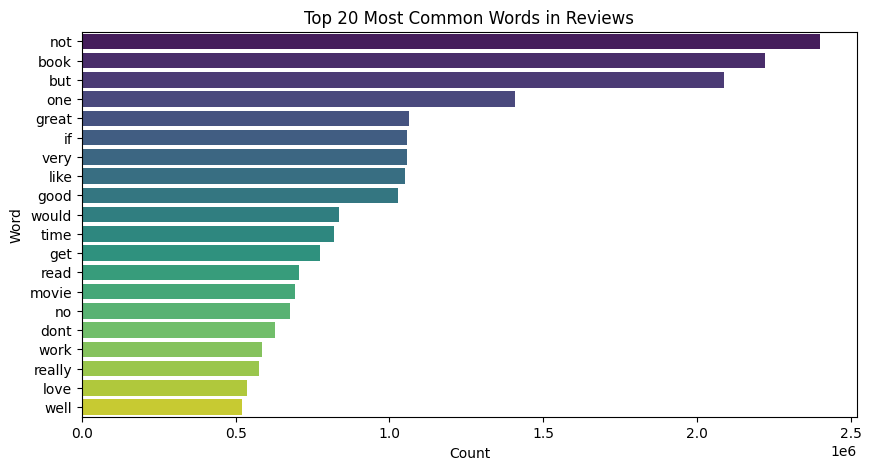

In [32]:
plt.figure(figsize=(10, 5))
sns.barplot(x='count', y='word', data=common_words_df, palette='viridis')
plt.title('Top 20 Most Common Words in Reviews')
plt.xlabel('Count')
plt.ylabel('Word')
plt.show()

In [33]:
train_df=train_df[['label', 'cleaned_text']]

In [37]:
# Example: delete large intermediate DataFrames
del chunks
del unique_chunks
del all_words
del common_words
del common_words_df

In [38]:
from wordcloud import WordCloud
neg_text = ' '.join(train_df[train_df['label'] == 1]['cleaned_text'])
wordcloud_neg = WordCloud(width=800, height=400, background_color='white').generate(neg_text)
pos_text = ' '.join(train_df[train_df['label'] == 2]['cleaned_text'])
wordcloud_pos = WordCloud(width=800, height=400, background_color='white').generate(pos_text)

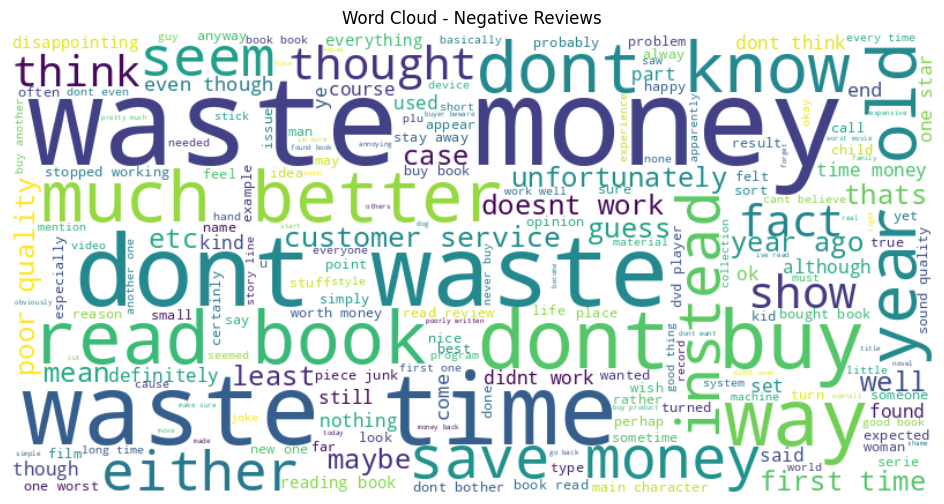

In [39]:
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Negative Reviews')
plt.show()

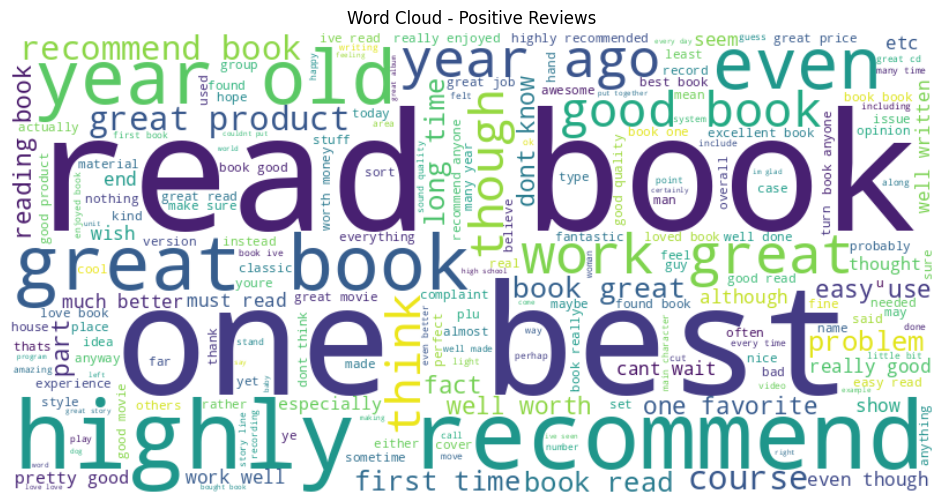

In [40]:
# Plot Positive
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Positive Reviews')
plt.show()

In [1]:
train_df.to_csv('cleaned_amazon_reviews.csv', index=False)
print("✅ Saved as 'amazon_reviews_train.csv'")

NameError: name 'train_df' is not defined

In [43]:
del train_df
del neg_text
del wordcloud_neg
del pos_text
del wordcloud_pos

In [44]:
import gc
gc.collect()

5058

# after clear memory ++++ reading saved data 